In [79]:
%matplotlib inline
import h5pyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import cKDTree
import imageio
from datetime import datetime
from pytz import timezone
import pytz

In [99]:
def load_data(year):
    path = f"/nrel/nsrdb/v3/nsrdb_{year}.h5"
    return h5pyd.File(path, 'r')

def load_state_data(f, state):
    # Full resolution subset of California
    meta = pd.DataFrame(f['meta'][:])
    s = meta.loc[meta['state'] == state.encode('ASCII')] # Note .h5 saves strings as bit-strings
    return s

def plot_state_ghi(f, timestamp, state, file_name):
    time_index = pd.to_datetime(f['time_index'][...].astype(str))
    timestep = np.where(time_index == timestamp)[0][0]
    data = f['ghi'][timestep][state.index]  # full-resolution subset
    df = state[['longitude', 'latitude']].copy()
    df['ghi'] = data / f['ghi'].attrs['psm_scale_factor'] # Get the ghi of every (longitude, latitude) in California
    df.plot.scatter(x='longitude', y='latitude', c='ghi',
                colormap='YlOrRd',
                title=utc_to_pst(str(time_index[timestep])))
    plt.savefig(file_name)
    # plt.show()
    
    
def plot_ghi(f, timestamp, coords, data):
    time_index = pd.to_datetime(f['time_index'][...].astype(str))
    timestep = np.where(time_index == timestamp)[0][0]
    # coords = f['coordinates'][:]
    # data = f['ghi'][timestep, ::10]   # extract ghi for every 10th location at a particular time
    df = pd.DataFrame() # Combine data with coordinates in a DataFrame
    df['longitude'] = coords[::10, 1]
    df['latitude'] = coords[::10, 0]
    df['ghi'] = data / f['ghi'].attrs['psm_scale_factor'] # unscale dataset
    
    df.plot.scatter(x='longitude', y='latitude', c='ghi',
        colormap='YlOrRd',
        title=str(time_index[timestep]))
    plt.show()

def utc_to_pst(time):
    date_format = '%Y-%m-%d %H:%M:%S'
    
    date = datetime.strptime(time, date_format)
    date = pytz.utc.localize(date)
    # print(f'UTC time is: {date.strftime(date_format)}')
    date = date.astimezone(timezone('US/Pacific'))
    # print(f'PST time is: {date.strftime(date_format)}')
    return date.strftime(date_format)


In [96]:
utc_to_pst('2018-01-01 16:00:00')

UTC time is: 2018-01-01 16:00:00
PST time is: 2018-01-01 08:00:00


In [61]:
f = load_data(2018)

In [103]:
time_index = pd.to_datetime(f['time_index'][...].astype(str))
timestamp = '2018-01-01 00:00:00'
timestep = np.where(time_index == timestamp)[0][0]
coords = f['coordinates'][:]
data = f['ghi'][timestep, ::10]

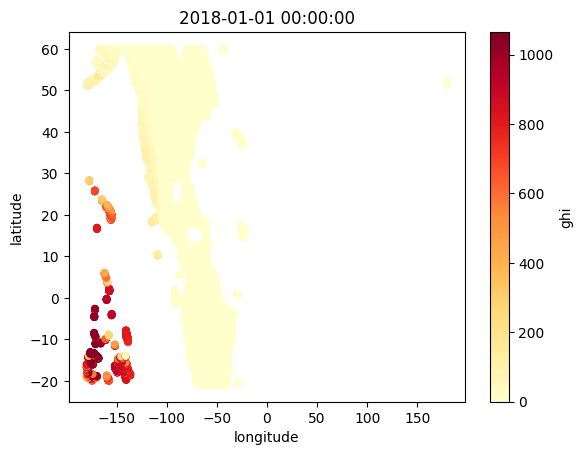

In [104]:
# Plot the ghi for all coordinates
plot_ghi(f, '2018-01-01 00:00:00', coords, data)

In [105]:
# Get the dataset of a given state
state_name = 'California'
california = load_state_data(f, state_name)

/var/folders/wg/y5qyxqr51mq214bkr4zp20940000gn/T/ipykernel_46059/1680145344.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_name))
/var/folders/wg/y5qyxqr51mq214bkr4zp20940000gn/T/ipykernel_46059/1680145344.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_name))
/var/folders/wg/y5qyxqr51mq214bkr4zp20940000gn/T/ipykernel_46059/1680145344.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning di

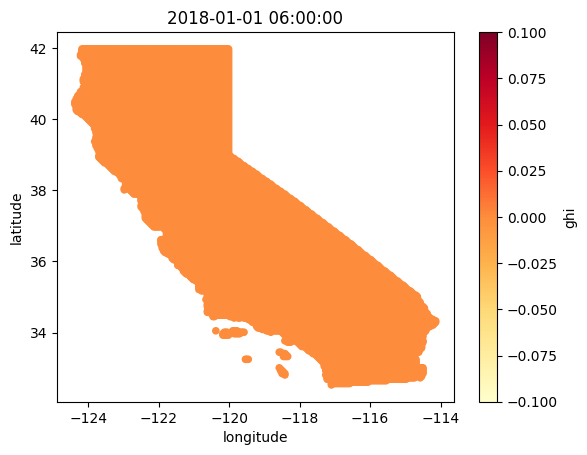

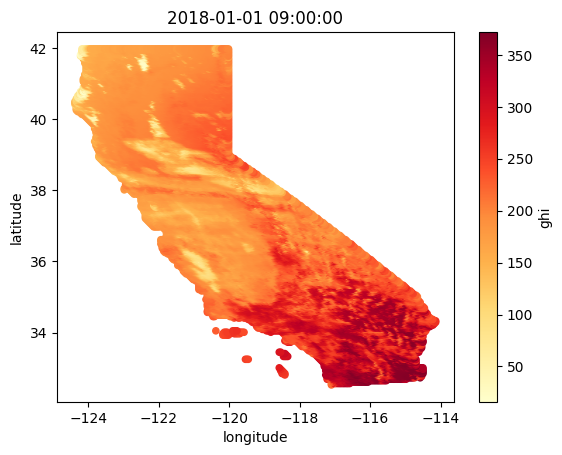

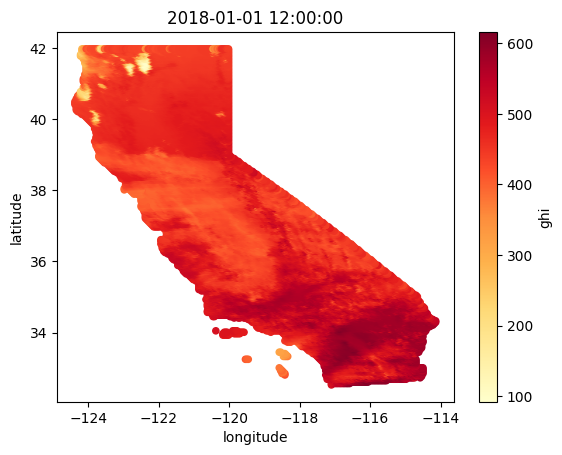

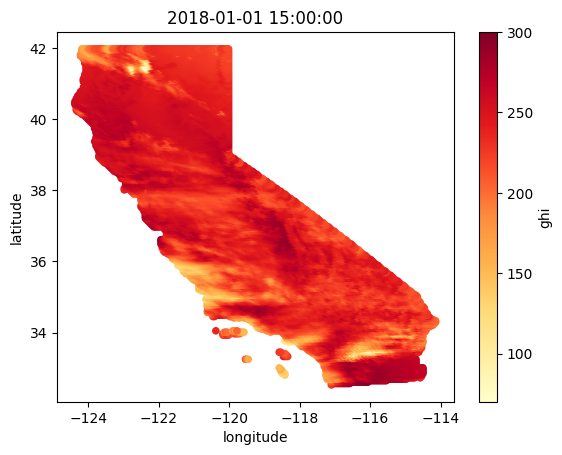

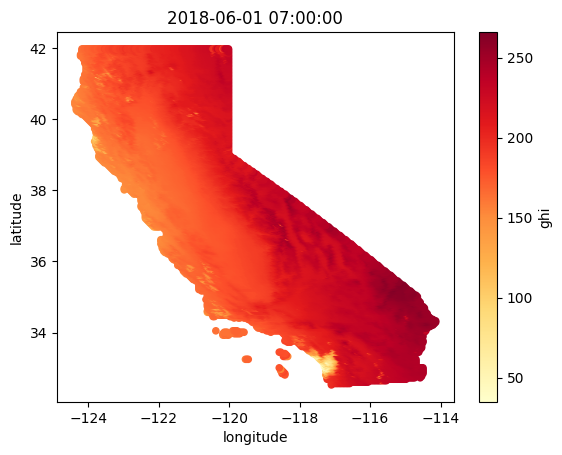

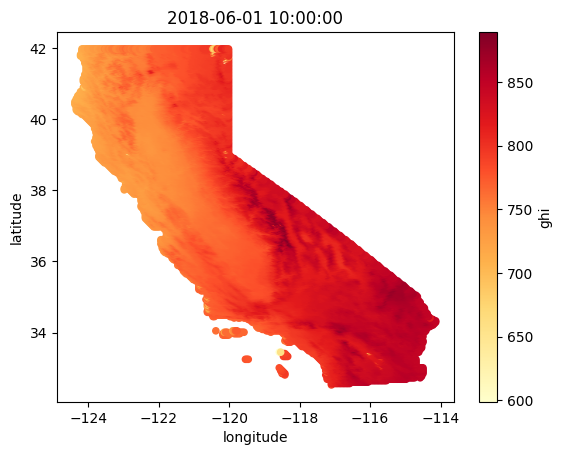

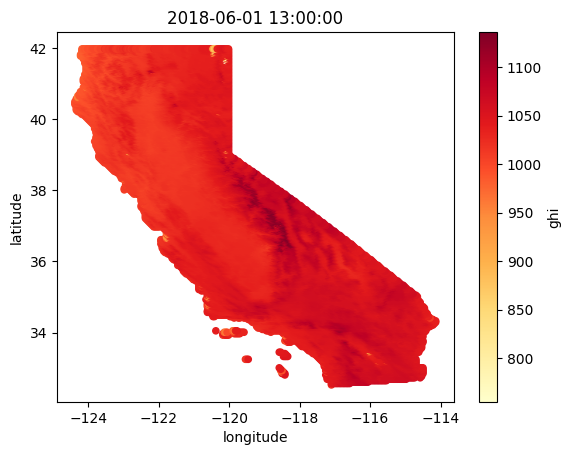

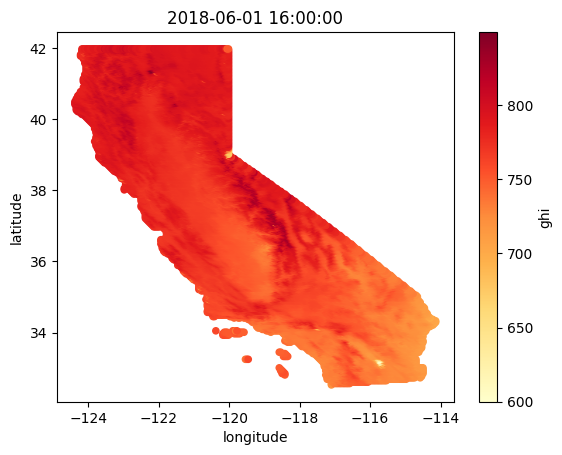

In [100]:
# Plot state heatmaps and save them
state_name = 'California'
california = load_state_data(f, state_name)

date_arr = ['2018-01-01', '2018-06-01']
time_arr = ['14:00:00', '17:00:00', '20:00:00', '23:00:00']
images = []
for i in date_arr:
    for j in time_arr:
        timestamp = i + ' ' + j
        timestep = np.where(time_index == timestamp)[0][0]
        file_name = state_name+'_'+timestamp+'_'+'heatmap.jpg'
        plot_state_ghi(f, timestamp, california, file_name)
        images.append(imageio.imread(file_name))
        
imageio.mimsave('test.gif', images)

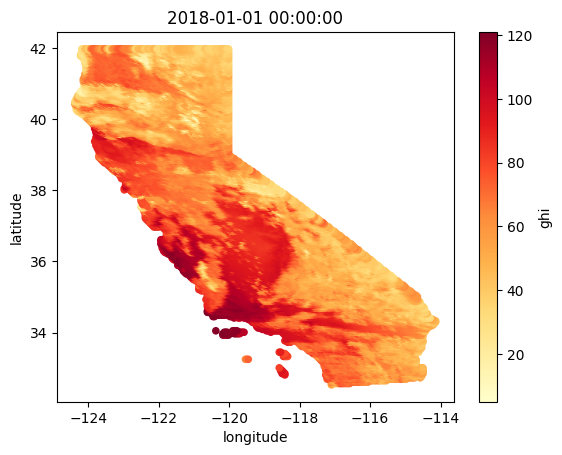

In [69]:
file_name = state_name+'_'+timestamp+'_'+'heatmap.jpg'
plot_state_ghi(f, timestamp, california, file_name)

## Nearest Timeseries for given Lat/Lon

In [ ]:
# Plot the ghi for whole year of a given coordinate
# Unlike the gridded WTK data the NSRDB is provided as sparse time-series dataset.
# The quickest way to find the nearest site it using a KDtree

# coords = f['coordinates'][:]
tree = cKDTree(coords)
def nearest_site(tree, lat_coord, lon_coord):
    lat_lon = np.array([lat_coord, lon_coord])
    dist, pos = tree.query(lat_lon)
    return pos

NewYorkCity = (40.7128, -74.0059)
NewYorkCity_idx = nearest_site(tree, NewYorkCity[0], NewYorkCity[1] )

print("Site index for New York City: \t\t {}".format(NewYorkCity_idx))
print("Coordinates of New York City: \t {}".format(NewYorkCity))
print("Coordinates of nearest point: \t {}".format([NewYorkCity_idx]))